<a href="https://colab.research.google.com/github/anthonyykim/test/blob/main/Final_Transformers_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')


Mounted at /content/drive


Loaded pretrained ViT weights into transformer stages.

==== Batch element 0 – pred_low (90×160) ====
min: 0.0 max: 1.7526185e-16 mean: 6.197339e-20

==== Batch element 0 – pred_high (360×640) ====
min: 0.0 max: 1.6459269e-16 mean: 6.197339e-20

==== Batch element 0 – gt_low (90×160) ====
min: 0.0 max: 1.6060652 mean: 0.029583333

Starting Stage 2 training...

Stage2, Epoch 01/20: TrainLoss=6.260256 | ValMAE=367.49 | ValRMSE=483.93 | ValMAPE=132.22% | LR=1.00e-06
Stage2, Epoch 02/20: TrainLoss=3.162939 | ValMAE=348.91 | ValRMSE=453.60 | ValMAPE=100.00% | LR=4.08e-05
Stage2, Epoch 03/20: TrainLoss=3.155889 | ValMAE=348.91 | ValRMSE=453.60 | ValMAPE=100.00% | LR=8.06e-05
Stage2, Epoch 04/20: TrainLoss=3.155888 | ValMAE=348.91 | ValRMSE=453.60 | ValMAPE=100.00% | LR=1.20e-04
Stage2, Epoch 05/20: TrainLoss=3.155889 | ValMAE=348.91 | ValRMSE=453.60 | ValMAPE=100.00% | LR=1.60e-04
Stage2, Epoch 06/20: TrainLoss=3.155889 | ValMAE=348.91 | ValRMSE=453.60 | ValMAPE=100.00% | LR=2.00e-04
Stage2,

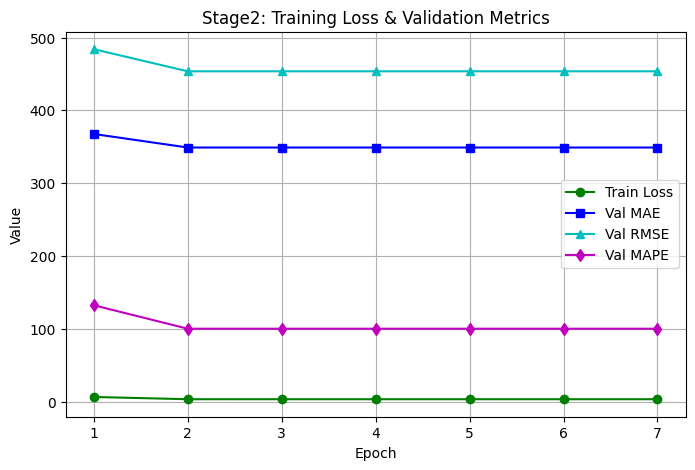

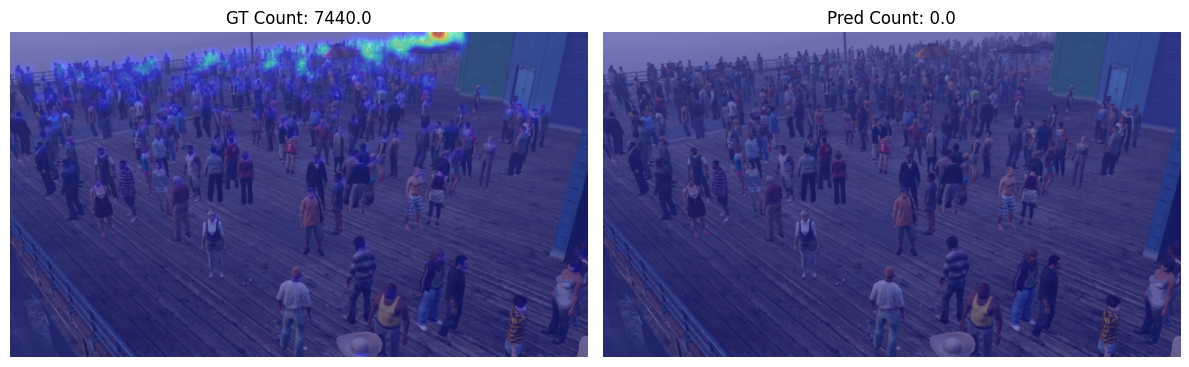

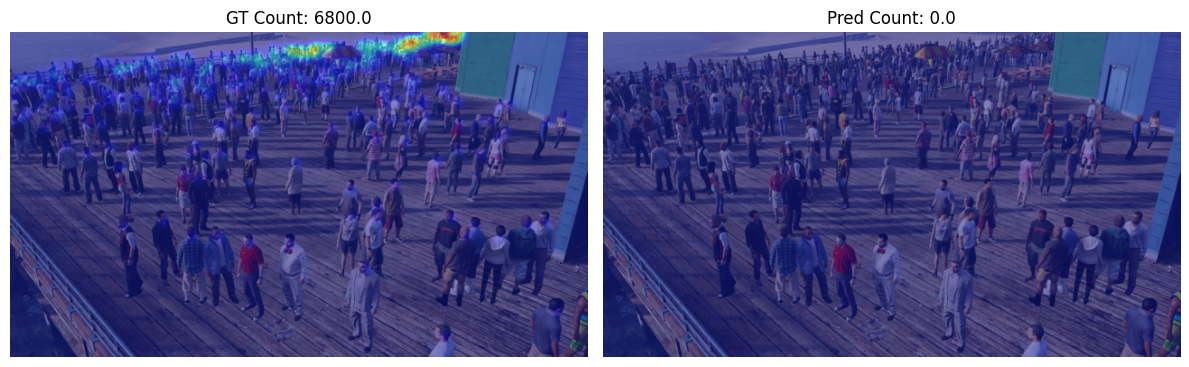

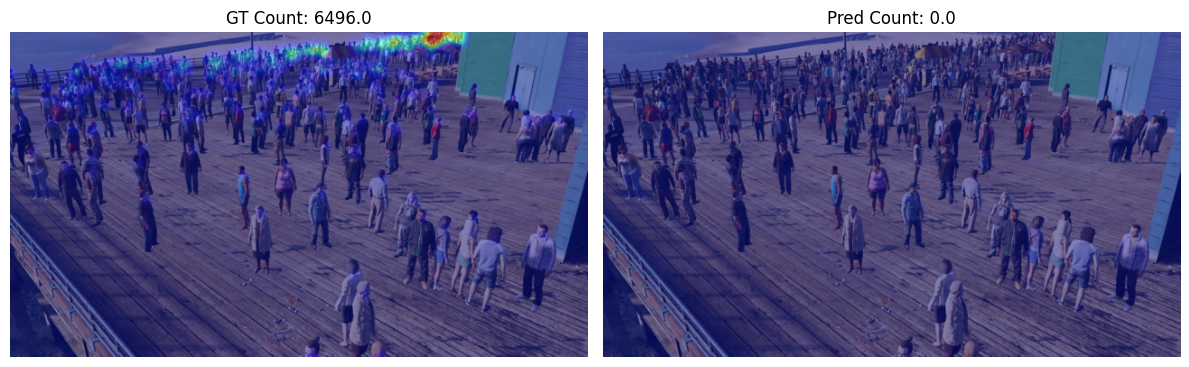

In [19]:
"""
Stage 2: Fine‐Tune CrowdFormer on GTA_Head’s True Density Maps at 90×160 resolution.

This code:
• Builds a modified CrowdDataset90 that generates 90×160 ground‐truth density maps.
• Adapts CrowdFormer so its regression head predicts a 90×160 density, then upsamples internally to 360×640.
• Uses a combined loss: pixel‐wise MSE + MAE on counts.
• Trains for up to 20 epochs on the 700 train images; computes MAE, MSE (RMSE), and MAPE on 150 validation images each epoch.
• Implements early stopping if validation MAE does not improve for 3 consecutive epochs.
• Logs (“Stage2, Epoch X: MAE=…, MSE=…, MAPE=…”) and saves the best checkpoint.
"""

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
import torchvision.transforms as T

from scipy.ndimage import gaussian_filter

# ----------------------------
# Mount Google Drive (Colab)
# ----------------------------
try:
    base_path = "/content/drive/MyDrive/Colab_Notebooks/GTA_Head/GTA_Head"
    if not os.path.exists(base_path):
        from google.colab import drive
        drive.mount('/content/drive')
except:
    pass

# Install timm if needed
try:
    import timm
except ImportError:
    !pip install timm
    import timm

# ----------------------------
# Dataset Definition (90×160 density)
# ----------------------------
class CrowdDataset90(Dataset):
    """Dataset for GTA_Head that outputs images (3×360×640) and 90×160 density maps."""
    def __init__(self, root_dir, split="train", transform=None):
        """
        root_dir: base directory containing train/ and test/.
        split: "train" or "test".
        transform: torchvision transforms for input image.
        """
        self.root_dir = root_dir
        self.split = split.lower()
        self.transform = transform

        split_dir = os.path.join(root_dir, split)
        if not os.path.isdir(split_dir):
            raise FileNotFoundError(f"Split directory not found: {split_dir}")

        self.img_paths = []
        self.gt_paths = []

        # Collect all image paths and their corresponding gt.txt
        for scene_name in sorted(os.listdir(split_dir)):
            scene_path = os.path.join(split_dir, scene_name)
            if not os.path.isdir(scene_path):
                continue
            img1_dir = os.path.join(scene_path, "img1")
            gt_file = os.path.join(scene_path, "gt", "gt.txt")
            if not os.path.isdir(img1_dir) or not os.path.isfile(gt_file):
                continue
            for fname in sorted(os.listdir(img1_dir)):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.img_paths.append(os.path.join(img1_dir, fname))
                    self.gt_paths.append(gt_file)

        if len(self.img_paths) == 0:
            raise FileNotFoundError(f"No images found under {split_dir}/<scene>/img1")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        gt_path = self.gt_paths[idx]

        # --- Load and preprocess image (360×640) ---
        image = Image.open(img_path).convert("RGB")
        image = image.resize((640, 360), Image.BILINEAR)
        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        # --- Build 90×160 density map (downsample factor = 4) ---
        # Original GT resolution: 1080×1920; resized image is 360×640.
        # We want density grid of size 90×160 (i.e., 360/4 × 640/4).
        w_out, h_out = 160, 90  # width, height of the low-res density map
        density = np.zeros((h_out, w_out), dtype=np.float32)

        # Determine frame_id from filename
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        frame_id = int(base_name)

        with open(gt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue
                fid = int(float(parts[0]))
                if fid != frame_id:
                    continue
                x_min = float(parts[2])
                y_min = float(parts[3])
                w = float(parts[4])
                h = float(parts[5])
                # Head center in original coords
                cx = x_min + w / 2.0
                cy = y_min + h / 2.0
                # Scale to resized image (360×640)
                cx = cx * (640.0 / 1920.0)
                cy = cy * (360.0 / 1080.0)
                # Map to low-res grid (160×90)
                cx_lr = cx * (w_out / 640.0)
                cy_lr = cy * (h_out / 360.0)
                px = int(round(cx_lr))
                py = int(round(cy_lr))
                if 0 <= px < w_out and 0 <= py < h_out:
                    density[py, px] += 1.0

        # Gaussian blur on low-res
        sigma = 4.0 / 4.0  # downscale sigma proportionally (original σ=4 at 360×640 becomes σ=1 at 90×160)
        density = gaussian_filter(density, sigma=sigma)
        density_tensor = torch.from_numpy(density).unsqueeze(0)  # shape (1, 90, 160)

        return image, density_tensor

# ----------------------------
# Data Preparation & Loader
# ----------------------------
data_root = "/content/drive/MyDrive/Colab_Notebooks/GTA_Head/GTA_Head"
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load full train split, then subset 700 and 150 for val
full_train_set90 = CrowdDataset90(data_root, split="train", transform=img_transform)
assert len(full_train_set90) >= 850, "Expect ≥ 850 train images"
train_indices = list(range(0, 700))
val_indices   = list(range(700, 850))
train_set90 = Subset(full_train_set90, train_indices)
val_set90   = Subset(full_train_set90, val_indices)

# Load test split (for later)
test_set90 = CrowdDataset90(data_root, split="test", transform=img_transform)

# DataLoaders
batch_size = 4  # can increase since low-res GT maps save memory
train_loader90 = DataLoader(train_set90, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader90   = DataLoader(val_set90,   batch_size=1,            shuffle=False, num_workers=1, pin_memory=True)
test_loader90  = DataLoader(test_set90,  batch_size=1,            shuffle=False, num_workers=1, pin_memory=True)


# ----------------------------
# Model Adjustment for Stage 2
# ----------------------------

class PSigmoid(nn.Module):
    """Parametric Sigmoid activation (P-Sigmoid) for final density output."""
    def __init__(self, init_a=1.0):
        super(PSigmoid, self).__init__()
        # a is a learnable parameter that scales the sigmoid output
        self.a = nn.Parameter(torch.tensor(init_a, dtype=torch.float32))

    def forward(self, x):
        # x_out = a / (1 + exp(-x))
        return self.a / (1 + torch.exp(-x))

class OverlapTransformerBlock(nn.Module):
    """Transformer block with multi-head self-attention (global) and overlapping patch embedding (downsampling conv)."""
    def __init__(self, dim, num_heads, sr_ratio=1):
        """
        dim: input (and output) feature dimension.
        num_heads: number of attention heads.
        sr_ratio: spatial reduction ratio for keys/values (for efficiency).
        """
        super(OverlapTransformerBlock, self).__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim = dim
        self.num_heads = num_heads
        self.sr_ratio = sr_ratio

        # LayerNorm for pre-normalization
        self.norm = nn.LayerNorm(dim)
        # Multi-head self-attention components
        # Using one Linear layer for qkv combined for efficiency (will split internally)
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        # Overlapping patch embedding (convolution for downsampling)
        # We'll set conv in parent model since stride and out_channels may depend on stage.
        self.conv_down = None  # will be set in the Stage-2 constructor

    def forward(self, x):
        """
        x: input feature map tensor of shape (B, C, H, W).
        Returns the output feature map tensor of next stage (B, C_out, H_out, W_out).
        """
        B, C, H, W = x.shape
        # Flatten spatial into sequence for attention: shape (B, N, C)
        N = H * W
        # Pre-norm
        seq = x.flatten(2).transpose(1, 2)  # (B, N, C)
        seq = self.norm(seq)
        # Compute Q, K, V
        qkv = self.qkv(seq)  # (B, N, 3*dim)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads)
        # Split into q, k, v and transpose to shape (B, num_heads, N, dim_per_head)
        q = qkv[:, :, 0].permute(0, 2, 1, 3)  # (B, heads, N, d_head)
        k = qkv[:, :, 1].permute(0, 2, 1, 3)
        v = qkv[:, :, 2].permute(0, 2, 1, 3)

        # If using spatial reduction for k, v:
        if self.sr_ratio > 1:
            # Downsample input x for K and V with average pooling
            x_down = F.avg_pool2d(x, kernel_size=self.sr_ratio, stride=self.sr_ratio)  # (B, C, H_down, W_down)
            B_d, C_d, H_down, W_down = x_down.shape
            N_down = H_down * W_down

            # Flatten and normalize
            seq_down = x_down.flatten(2).transpose(1, 2)  # (B, N_down, C)
            seq_down = self.norm(seq_down)

            # Create separate Linear layers for k and v on first use
            if not hasattr(self, "proj_k"):
                self.proj_k = nn.Linear(C, C)
                self.proj_v = nn.Linear(C, C)
                # Copy weights and bias out of qkv for k, v
                self.proj_k.weight.data.copy_(self.qkv.weight[self.dim : 2 * self.dim, :])
                self.proj_k.bias.data.copy_(self.qkv.bias[self.dim : 2 * self.dim])
                self.proj_v.weight.data.copy_(self.qkv.weight[2 * self.dim : 3 * self.dim, :])
                self.proj_v.bias.data.copy_(self.qkv.bias[2 * self.dim : 3 * self.dim])
                # Move them onto x’s device
                self.proj_k = self.proj_k.to(x.device)
                self.proj_v = self.proj_v.to(x.device)

            # Project downsampled tokens to k and v
            k_seq = self.proj_k(seq_down)  # (B, N_down, C)
            v_seq = self.proj_v(seq_down)  # (B, N_down, C)

            # Reshape to (B, heads, N_down, d_head)
            k = k_seq.view(B_d, N_down, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
            v = v_seq.view(B_d, N_down, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        else:
            # No spatial reduction → k, v remain as originally computed
            k = k
            v = v

        # Multi-head attention:
        d_head = C // self.num_heads
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_head)  # (B, heads, N, N_k)
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_probs, v)  # (B, heads, N, d_head)
        attn_out = attn_out.permute(0, 2, 1, 3).reshape(B, N, C)  # (B, N, C)
        attn_out = self.proj(attn_out)  # (B, N, C)

        # Residual connection (pre‐norm style)
        x_flat_no_norm = x.flatten(2).transpose(1, 2)  # (B, N, C) before norm
        out_seq = x_flat_no_norm + attn_out

        # Reshape back to (B, C, H, W)
        out_feat = out_seq.transpose(1, 2).view(B, C, H, W)

        # Convolutional downsampling (overlapping patch embedding) if defined
        if self.conv_down is not None:
            out_feat = self.conv_down(out_feat)

        return out_feat



class CrowdFormerStage2(nn.Module):
    """
    CrowdFormer adapted to predict 90×160 density internally and upsample to 360×640 for loss.
    The regression head outputs (B,1,90,160); we upsample that to (B,1,360,640) before comparing to high-res GT.
    """
    def __init__(self, base_dim=384, num_heads=6, stages=3, use_pretrained=True):
        super(CrowdFormerStage2, self).__init__()
        self.base_dim = base_dim
        self.num_heads = num_heads
        self.stages = stages

        # Local CNN embedding: input 360×640 → intermediate 45×80
        self.local_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # (B,64,180,320)
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (B,128,90,160)
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# (B,256,45,80)
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, base_dim, kernel_size=1, stride=1, padding=0), # (B,384,45,80)
            nn.BatchNorm2d(base_dim), nn.ReLU(inplace=True)
        )

        # Transformer stages (same as Stage1)
        self.transformer_stages = nn.ModuleList()
        self.cfu_convs = nn.ModuleList()
        sr_ratios = [4, 2, 1]
        for i in range(stages):
            blk = OverlapTransformerBlock(dim=base_dim, num_heads=num_heads, sr_ratio=sr_ratios[i])
            conv_down = nn.Conv2d(base_dim, base_dim, kernel_size=3, stride=2, padding=1)
            blk.conv_down = conv_down
            self.transformer_stages.append(blk)
            self.cfu_convs.append(nn.Conv2d(base_dim, 256, kernel_size=1, stride=1, padding=0))

        # Regression head: output low-res 90×160 map
        final_in = 256 * stages
        self.reg_head = nn.Conv2d(final_in, 1, kernel_size=1, stride=1, padding=0)
        # We will upsample output to (360,640) for computing loss
        self.p_sigmoid = nn.ReLU(inplace=True)

        self._initialize_weights()
        if use_pretrained:
            self._load_pretrained_vit_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0.0)
                nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(self.reg_head.bias, 0.1)


    def _load_pretrained_vit_weights(self):
        try:
            vit = timm.create_model('vit_small_patch16_224', pretrained=True)
        except:
            print("Could not load pretrained ViT; proceeding without it.")
            return
        vit_blocks = list(vit.blocks.children())
        num_pre = len(vit_blocks)
        num_copy = min(self.stages, num_pre)
        for i in range(num_copy):
            vit_blk = vit_blocks[i]
            our_blk = self.transformer_stages[i]
            if hasattr(vit_blk, 'norm1') and hasattr(our_blk, 'norm'):
                our_blk.norm.weight.data.copy_(vit_blk.norm1.weight.data)
                our_blk.norm.bias.data.copy_(vit_blk.norm1.bias.data)
            if hasattr(vit_blk.attn, 'qkv') and hasattr(our_blk, 'qkv'):
                if vit_blk.attn.qkv.weight.shape == our_blk.qkv.weight.shape:
                    our_blk.qkv.weight.data.copy_(vit_blk.attn.qkv.weight.data)
                    our_blk.qkv.bias.data.copy_(vit_blk.attn.qkv.bias.data)
            if hasattr(vit_blk.attn, 'proj') and hasattr(our_blk, 'proj'):
                our_blk.proj.weight.data.copy_(vit_blk.attn.proj.weight.data)
                our_blk.proj.bias.data.copy_(vit_blk.attn.proj.bias.data)
        print("Loaded pretrained ViT weights into transformer stages.")

    def forward(self, x):
        B, _, H, W = x.shape  # H=360, W=640
        # Local embedding → (B,384,45,80)
        feat = self.local_conv(x)
        features = []
        out = feat
        for blk, cfu in zip(self.transformer_stages, self.cfu_convs):
            out = blk(out)          # each stage downsample by 2
            f = cfu(out)            # (B,256,H_stage, W_stage)
            features.append(f)
        # Upsample each feature to low-res target 90×160
        target_lr = (90, 160)
        up_feats = [F.interpolate(f, size=target_lr, mode='bilinear', align_corners=False)
                    for f in features]  # list of 3 tensors, each (B,256,90,160)
        fuse = torch.cat(up_feats, dim=1)  # (B,256*3,90,160)
        low_res = self.reg_head(fuse)      # (B,1,90,160)
        low_res = self.p_sigmoid(low_res)  # ensure non-negative
        # Upsample to high-res 360×640 for loss comparison
        high_res = F.interpolate(low_res, size=(H, W), mode='bilinear', align_corners=False)
        return high_res, low_res  # return both resolutions if needed

# Instantiate Stage 2 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrowdFormerStage2(base_dim=384, num_heads=6, stages=3, use_pretrained=True).to(device)


# --- snippet: inspect raw outputs of CrowdFormerStage2 on one batch ---

# 1) Pull a single batch from the training loader (you could also use val_loader90)
images, gt_low = next(iter(train_loader90))  # images: (B,3,360,640), gt_low: (B,1,90,160)
images = images.to(device)

# 2) Run a forward pass through your Stage-2 model
model.eval()
with torch.no_grad():
    pred_high, pred_low = model(images)
    # pred_high: (B,1,360,640), pred_low: (B,1,90,160)

# 3) Move everything to CPU and convert to numpy for printing
pred_low_np  = pred_low.cpu().numpy()   # shape (B,1,90,160)
pred_high_np = pred_high.cpu().numpy()  # shape (B,1,360,640)
gt_low_np    = gt_low.numpy()           # (B,1,90,160)   (still on CPU)
# note: gt_low was already on CPU since DataLoader pin_memory=True but no .to(device) for it

# 4) Print basic stats for batch‐element 0
b = 0  # index within the batch
print(f"\n==== Batch element {b} – pred_low (shape {pred_low_np.shape[1:]}) ====")
print("min:", pred_low_np[b,0].min(),
      "max:", pred_low_np[b,0].max(),
      "mean:", pred_low_np[b,0].mean())
print("\nRaw pred_low values (90×160) for element 0:")
print(pred_low_np[b,0])   # will print a 90×160 array of floats

print(f"\n==== Batch element {b} – pred_high (shape {pred_high_np.shape[1:]}) ====")
print("min:", pred_high_np[b,0].min(),
      "max:", pred_high_np[b,0].max(),
      "mean:", pred_high_np[b,0].mean())
print("\nRaw pred_high values (360×640) for element 0:")
print(pred_high_np[b,0])  # will print a large 360×640 array

print(f"\n==== Batch element {b} – ground‐truth low‐res (shape {gt_low_np.shape[1:]}) ====")
print("min:", gt_low_np[b,0].min(),
      "max:", gt_low_np[b,0].max(),
      "mean:", gt_low_np[b,0].mean())
print("\nRaw gt_low values (90×160) for element 0:")
print(gt_low_np[b,0])


# ----------------------------
# Loss, optimizer, scheduler
# ----------------------------
mse_loss = nn.MSELoss(reduction='mean')
mae_loss = nn.L1Loss(reduction='mean')

phase1_epochs  = 3

optimizer = torch.optim.AdamW([
    {"params": model.local_conv.parameters(),        "lr": 1e-5},
    {"params": model.transformer_stages.parameters(), "lr": 1e-5},
    {"params": model.cfu_convs.parameters(),         "lr": 1e-5},
    {"params": model.reg_head.parameters(),          "lr": 2e-6},
], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


# ----------------------------
# Training Loop with Combined Loss + Early Stopping
# ----------------------------
num_epochs = 20
best_val_mae = float('inf')
no_improve_epochs = 0
patience = 5

# Logs
val_metrics_log = []  # store (epoch, MAE, RMSE, MAPE)

# Directory for outputs
output_dir = os.path.join(data_root, "stage2_outputs")
os.makedirs(output_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for images, gt_low in train_loader90:
        images = images.to(device)              # (B,3,360,640)
        gt_low = gt_low.to(device)              # (B,1,90,160)
        optimizer.zero_grad()
        pred_high, pred_low = model(images)     # pred_high: (B,1,360,640); pred_low: (B,1,90,160)
        if torch.isnan(pred_low).any() or torch.isnan(pred_high).any():
          print(">>> NaN detected in model output at epoch", epoch)
          # Optionally you can even break or raise an error here so you can debug that batch.
          break

        # Compute combined loss:
        # 1) MSE on low-res maps
        loss_mse = mse_loss(pred_low, gt_low)
        # 2) MAE on counts (sum low-res)
        pred_count = pred_low.sum(dim=(2,3))
        true_count = gt_low.sum(dim=(2,3))
        loss_mae = mae_loss(pred_count, true_count)
        # Combine with weighting (e.g., λ_density=1.0, λ_count=0.01)
        loss = loss_mse + 0.01 * loss_mae

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader90.dataset)

    # Step scheduler
    scheduler.step()


    # — PHASE TRANSITION at end of epoch “phase1_epochs” —
    if epoch == phase1_epochs:
        # 1) swap ReLU → PSigmoid
        model.p_sigmoid = PSigmoid(init_a=0.01).to(device)

        # 2) rebuild optimizer & rebuild scheduler
        phase2_lr       = 1e-6
        phase2_head_lr  = 5e-7
        phase2_a_lr     = 1e-3
        optimizer = torch.optim.AdamW([
            {"params": model.local_conv.parameters(),        "lr": phase2_lr},
            {"params": model.transformer_stages.parameters(), "lr": phase2_lr},
            {"params": model.cfu_convs.parameters(),          "lr": phase2_lr},
            {"params": model.reg_head.parameters(),           "lr": phase2_head_lr},
            {"params": model.p_sigmoid.parameters(),          "lr": phase2_a_lr},
        ], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)




    # --- Validation ---
    model.eval()
    val_mae = 0.0
    val_mse_sum = 0.0
    val_mape_sum = 0.0
    with torch.no_grad():
        for images, gt_low in val_loader90:
            images = images.to(device)
            gt_low = gt_low.to(device)
            pred_high, pred_low = model(images)

            # Validation metrics on counts from low-res
            pred_count = pred_low.sum().item()
            true_count = gt_low.sum().item()
            err = pred_count - true_count
            val_mae += abs(err)
            val_mse_sum += (err ** 2)
            if true_count > 0:
                val_mape_sum += abs(err) / true_count * 100.0

    val_mae /= len(val_loader90)
    val_rmse = math.sqrt(val_mse_sum / len(val_loader90))
    val_mape = val_mape_sum / len(val_loader90)
    val_metrics_log.append((epoch, val_mae, val_rmse, val_mape))

    # Logging
    print(f"Stage 2, Epoch {epoch}/{num_epochs}: MAE = {val_mae:.2f}, RMSE = {val_rmse:.2f}, MAPE = {val_mape:.2f}%")

    # Check early stopping on MAE
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        no_improve_epochs = 0
        # Save best checkpoint
        torch.save(model.state_dict(), os.path.join(output_dir, "crowdformer_stage2_best.pth"))
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"No MAE improvement for {patience} epochs. Early stopping at epoch {epoch}.")
            break

# Save final model if not already saved
torch.save(model.state_dict(), os.path.join(output_dir, "crowdformer_stage2_final.pth"))

# Save validation metrics log to CSV
with open(os.path.join(output_dir, "stage2_val_metrics.csv"), "w") as f:
    f.write("epoch,MAE,RMSE,MAPE\n")
    for (e, mae, rmse, mape) in val_metrics_log:
        f.write(f"{e},{mae:.6f},{rmse:.6f},{mape:.6f}\n")

# ----------------------------
# Plot training loss and validation MAE/MSE/MAPE curves
# ----------------------------
epochs_done = [em[0] for em in val_metrics_log]
mae_vals    = [em[1] for em in val_metrics_log]
rmse_vals   = [em[2] for em in val_metrics_log]
mape_vals   = [em[3] for em in val_metrics_log]

plt.figure(figsize=(8,6))
plt.plot(epochs_done, mae_vals, label="Val MAE", marker='o')
plt.plot(epochs_done, rmse_vals, label="Val RMSE", marker='s')
plt.plot(epochs_done, mape_vals, label="Val MAPE", marker='^')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Stage 2 Validation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "stage2_val_metrics.png"))
plt.show()

# ----------------------------
# Qualitative Visualizations on Validation Set
# ----------------------------
model.eval()
# Pick first 3 validation samples for overlays
for idx in range(3):
    images, gt_low = val_set90[idx]
    # Convert image tensor back to uint8 for display
    img_display = images.clone()
    for c in range(3):
        img_display[c] = img_display[c] * torch.tensor([0.229,0.224,0.225])[c] + torch.tensor([0.485,0.456,0.406])[c]
    img_display = (img_display.clamp(0,1).permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

    # Ground truth high-res map (upsampled)
    gt_high = F.interpolate(gt_low.unsqueeze(0), size=(360,640), mode='bilinear', align_corners=False).squeeze(0).squeeze(0).cpu().numpy()
    with torch.no_grad():
        pred_high, pred_low = model(images.unsqueeze(0).to(device))
        pred_high_np = pred_high.squeeze(0).squeeze(0).cpu().numpy()

    # Normalize for overlay
    gt_norm = gt_high / (gt_high.max() + 1e-8)
    pred_norm = pred_high_np / (pred_high_np.max() + 1e-8)

    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].imshow(img_display)
    axes[0].imshow(gt_norm, cmap='jet', alpha=0.5)
    axes[0].set_title(f"GT Count: {gt_high.sum():.1f}")
    axes[0].axis('off')

    axes[1].imshow(img_display)
    axes[1].imshow(pred_norm, cmap='jet', alpha=0.5)
    axes[1].set_title(f"Pred Count: {pred_high_np.sum():.1f}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"stage2_vis_val_{idx}.png"))
    plt.show()
